## Construccion paso a paso de modelo ML

### Descripción del problema

In [ ]:
# Este proyecto aborda un problema de regresión supervisada en el contexto del análisis de variables biofisicas de la vegetación, 
# cuyo objetivo es predecir el Índice de Área Foliar (LAI) a partir de datos de reflectancia espectral 
# obtenidos por el satélite Sentinel-2. Se construye un modelo de machine learning que aprende la relación 
# entre las bandas espectrales y valores de LAI medidos in situ por la red NEON. La tarea consiste en entrenar, 
# validar y probar distintos algoritmos de regresión con el fin de encontrar un modelo preciso, generalizable 
# y eficiente para estimar LAI a gran escala espacial y temporal, cumpliendo con los criterios de incertidumbre 
# exigidos por los protocolos.

### Variables y librerías

Definimos variables importantes:

In [ ]:
file_name_sat = 'S2_SR_USA_2017_2024_SCL.csv'
file_name_insitu = 'NEON_LAI_USA_2017_2024.csv'

Importamos las librerías

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.stats import  pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from collections import Counter

import sys

# Agregar el directorio 'src/notebooks' al sys.path
module_path = os.path.abspath(os.path.join('..', 'utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Importar las funciones
from variables import COORDS as coords

In [ ]:
# Montamos nuestro Google Drive si usamos entorno de Colab
#from google.colab import drive
#drive.mount('/content/drive')

### 1. Datos de satelite

#### Cargamos el dataset de datos de satelite

Para entorno de **Google Colab**

In [ ]:
#drive_path = '/content/drive/MyDrive/Colab Notebooks/'
#!ls /content/drive/MyDrive/Colab\ Notebooks/
#dataset_path = drive_path + file_name_sat

Para entorno **local**

In [ ]:
# Definimos ruta de los archivos.
datadir_path = os.path.join('..','data')
dataset_path = os.path.join(datadir_path, file_name_sat)

**Importamos el dataset** con Pandas y visualizamos las primeras instancias

In [ ]:
df_sat = pd.read_csv(dataset_path, sep=',')

# Eliminamos columna innecesaria de indices importado
if 'Unnamed: 0' in df_sat.columns: # Comprobamos si 'Unnamed: 0' está en las columnas
    # Eliminar la columna 'Unnamed: 0'
    df_sat.drop(columns=['Unnamed: 0'], inplace=True) 
df_sat.head(5)

,id,longitude,latitude,time,B1,B2,B3,B4,B5,B6,...,B8,B8A,B9,B11,B12,SCL,QA10,QA20,QA60,Site_sat
0,20171222T182749_20171222T183128_T12TUK,-112.452455,40.177600,1513967574868,3597.0,3704.0,3788.0,3972.0,4316.0,4280.0,...,4272.0,4349.0,4724.0,1167.0,1091.0,11.0,NaN,NaN,0,Onaqui Ault
1,20171118T170559_20171118T170554_T15TYL,-89.586378,45.508922,1511025045890,8393.0,8072.0,7776.0,7568.0,7652.0,7527.0,...,7632.0,7314.0,10924.0,2087.0,2396.0,8.0,NaN,NaN,1024,Steigerwaldt Land Services
2,20171225T165709_20171225T165708_T15TYL,-89.586378,45.508922,1514221250709,3381.0,3469.0,3256.0,3317.0,3473.0,3863.0,...,4376.0,4062.0,3881.0,2315.0,1911.0,9.0,NaN,NaN,2048,Steigerwaldt Land Services
3,20171118T170559_20171118T170554_T15SUD,-95.192225,39.040513,1511025161923,7635.0,7848.0,7632.0,7480.0,7621.0,7438.0,...,7944.0,7295.0,10781.0,1901.0,2098.0,8.0,NaN,NaN,1024,University of Kansas Field Site
4,20171118T170559_20171118T170554_T15TYM,-89.537510,46.234042,1511025031342,5584.0,5352.0,5124.0,5016.0,5094.0,5038.0,...,4980.0,4760.0,6066.0,3001.0,2600.0,9.0,NaN,NaN,1024,Underc


In [ ]:
df_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22975 entries, 0 to 22974
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         22975 non-null  object 
 1   longitude  22975 non-null  float64
 2   latitude   22975 non-null  float64
 3   time       22975 non-null  int64  
 4   B1         22949 non-null  float64
 5   B2         22959 non-null  float64
 6   B3         22960 non-null  float64
 7   B4         22960 non-null  float64
 8   B5         22960 non-null  float64
 9   B6         22960 non-null  float64
 10  B7         22960 non-null  float64
 11  B8         22960 non-null  float64
 12  B8A        22960 non-null  float64
 13  B9         22963 non-null  float64
 14  B11        22960 non-null  float64
 15  B12        22960 non-null  float64
 16  SCL        22960 non-null  float64
 17  QA10       16075 non-null  float64
 18  QA20       16075 non-null  float64
 19  QA60       22975 non-null  int64  
 20  Site_s

#### Limpiamos y procesamos el dataset

Convertimos a tipo **datetime** la columna 'time' que está en formato Unix epoch time.

In [ ]:
#df_sat['time'] = df_sat['time'].apply(lambda x: dt.datetime.utcfromtimestamp(x / 1000))
df_sat['time'] = pd.to_datetime(df_sat['time'], unit='ms')

In [ ]:
df_sat['time']

0       2017-12-22 18:32:54.868
1       2017-11-18 17:10:45.890
2       2017-12-25 17:00:50.709
3       2017-11-18 17:12:41.923
4       2017-11-18 17:10:31.342
                  ...          
22970   2024-12-23 17:00:45.423
22971   2024-12-26 17:10:44.865
22972   2024-12-26 17:10:41.739
22973   2024-12-28 17:00:49.197
22974   2024-12-28 17:00:46.426
Name: time, Length: 22975, dtype: datetime64[ns]

**Ordenamos** el dataframe por Site y time, y **reseteamos** el indice.

In [ ]:
df_sat.sort_values(by=['Site_sat','time'], inplace=True)
df_sat.reset_index(drop=True, inplace=True)

**Eliminamos columnas innecesarias.**  
QA10 y QA20 son columnas vacias.  
También descartamos las bandas de 60m que corresponden a aerosoles y vapor de agua: B1 y B9

In [ ]:
columns_to_exclude = ['B1', 'B9', 'QA10', 'QA20']

In [ ]:
df_sat.drop(columns=columns_to_exclude, inplace=True)

**Eliminamos las filas** (espectros) correspondientes a **pixeles con nubes**  
Los pixes con nubes corresponden a: QA60 == 512 or QA60 == 1024 or QA60 == 2048  
Por lo tanto nos quedamos solo con los pixeles libres de nubes: QA60 == 0

In [ ]:
len(df_sat) # Antes de eliminar filas vemos el tamaño del dataset

22975

In [ ]:
df_sat['QA60'].value_counts() # También vemos la cantidad de pixeles con nubes

QA60
0       15915
1024     5244
2048     1816
Name: count, dtype: int64

In [ ]:
df_sat = df_sat[df_sat['QA60'] == 0] # Me quedo con las filas (pixeles) libre de nubes

In [ ]:
len(df_sat) # Vemos como queda el tamaño del dataset luego de eliminar pixeles con nubes

15915

**Elimino filas de no-vegetación**  
Me quedo con las filas (pixeles) de vegetación según la banda 'SCL' de Sentinel-2.  
Zonas de vegetación pueden estar cubiertas de nieve en alguna epoca del año.  
Por lo tanto, eliminamos esos pixeles.

In [ ]:
len(df_sat) # Antes de eliminar filas vemos el tamaño del dataset

15915

In [ ]:
df_sat = df_sat[df_sat['SCL'] == 4] # Me quedo con las filas (pixeles) de vegetación

In [ ]:
len(df_sat) # Vemos como queda el tamaño del dataset luego de eliminar pixeles

5547

**Escalamos las bandas** a los valores de reflectancia reales (originalmente están multiplicados por 10000).

In [ ]:
bandas = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12'] # Definimos una lista con las columnas correspondientes a las bandas

In [ ]:
for banda in bandas: # Recorremos todas las bandas
    df_sat.loc[:,banda] = df_sat[banda].astype(float) # Forzamos el tipo de los datos para hacerlos float.
    df_sat.loc[:,banda] = df_sat[banda] * 0.0001 # Escalamos

Vemos como queda nuestro dataset

In [ ]:
df_sat.head()

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,SCL,QA60,Site_sat
23,20190128T154519_20190128T154758_T19TCJ,-71.287337,44.063892,2019-01-28 15:50:57.000,0.0543,0.0520,0.0584,0.0665,0.1536,0.1727,0.2460,0.2054,0.0793,0.0550,4.0,0,Bartlett Experimental Forest
24,20190128T154519_20190128T154758_T18TYP,-71.287337,44.063892,2019-01-28 15:51:01.000,0.0251,0.0346,0.0358,0.0649,0.1531,0.1739,0.2365,0.2108,0.0815,0.0570,4.0,0,Bartlett Experimental Forest
33,20190222T154241_20190222T154730_T19TCJ,-71.287337,44.063892,2019-02-22 15:50:52.000,0.0642,0.0854,0.0816,0.0890,0.1784,0.2129,0.2199,0.2268,0.1014,0.0616,4.0,0,Bartlett Experimental Forest
34,20190222T154241_20190222T154730_T18TYP,-71.287337,44.063892,2019-02-22 15:50:56.000,0.0438,0.0541,0.0619,0.0842,0.1787,0.2139,0.1845,0.2290,0.1034,0.0623,4.0,0,Bartlett Experimental Forest
63,20190508T153819_20190508T154933_T19TCJ,-71.287337,44.063892,2019-05-08 15:51:05.057,0.0388,0.0560,0.0564,0.0942,0.1683,0.1943,0.2432,0.2120,0.1615,0.0985,4.0,0,Bartlett Experimental Forest


#### Visualización y exploración

Visualizamos muestras de los espectros de vegetación en un gráfico

In [ ]:
# Definimos la longitud de onda central de las bandas
central_wl = {
    'B2': 490,  # Banda 2 (Azul)
    'B3': 560,  # Banda 3 (Verde)
    'B4': 665,  # Banda 4 (Rojo)
    'B5': 705,  # Banda 5
    'B6': 740,  # Banda 6
    'B7': 783,  # Banda 7
    'B8': 842,  # Banda 8 (Infrarrojo cercano)
    'B8A': 865, # Banda 8A
    'B11': 1610, # Banda 11 (Infrarrojo de onda corta)
    'B12': 2190  # Banda 12
}

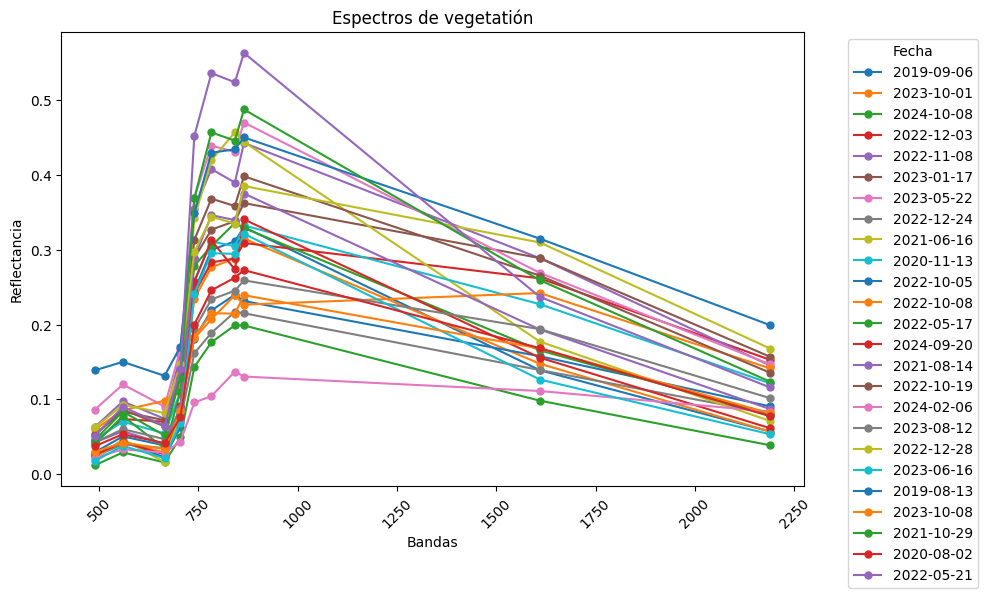

In [ ]:
# Graficar diferentes espectros
plt.figure(figsize=(10, 6))  # Definir tamaño de la figura

for index, row in df_sat.sample(25).iterrows():
    plt.plot([central_wl[band] for band in bandas], row[bandas], label=row['time'].strftime('%Y-%m-%d'), marker='o', linestyle='-', markersize=5)

# Configuración del gráfico
plt.title("Espectros de vegetatión")
plt.xlabel("Bandas")
plt.ylabel("Reflectancia")
plt.legend(title="Fecha", bbox_to_anchor=(1.05, 1), loc='upper left')  # Mueve la leyenda fuera de la gráfica

# Mostrar gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas de las bandas
plt.tight_layout()  # Ajustar el espacio
plt.show();

Calculamos el NDVI y graficamos series temporales de muestras de pixeles para verificar que se aproxima a la realidad

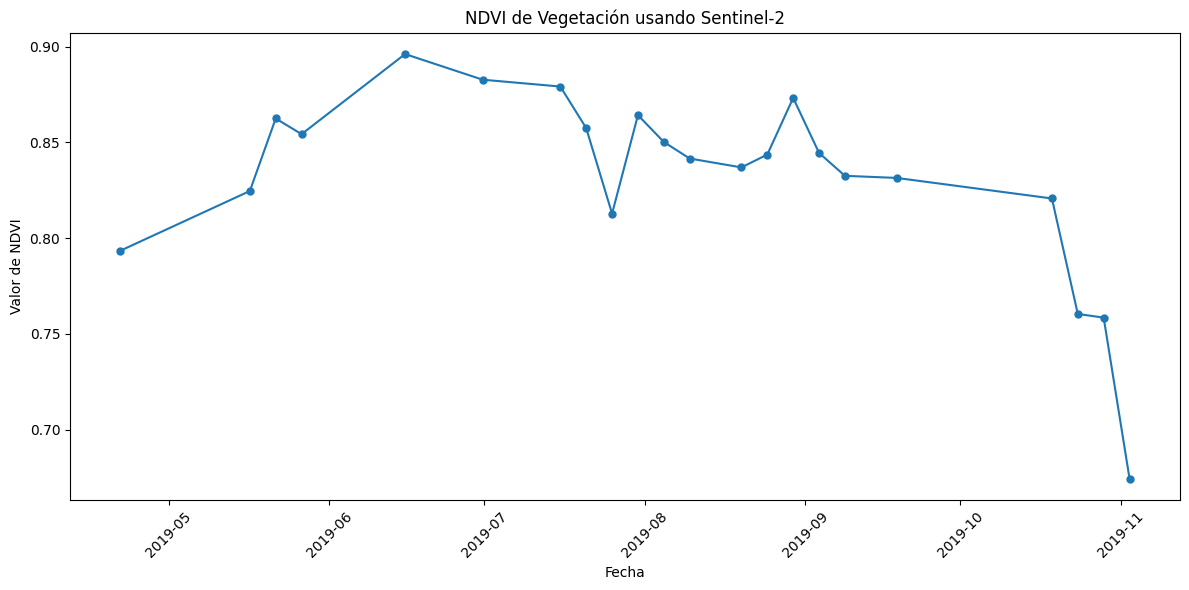

In [ ]:
# Calcular NDVI para cada espectro (fila) del DataFrame
df_VI = df_sat.copy()
df_VI['NDVI'] = (df_VI['B8'] - df_VI['B4']) / (df_VI['B8'] + df_VI['B4'])

# Graficar el NDVI para el site y el año seleccionado
plt.figure(figsize=(12, 6))
mask_Lajas_2019 = (df_VI['Site_sat'] == 'Smithsonian Environmental Research Center') & (df_VI['time'].dt.year == 2019)
plt.plot(df_VI.loc[mask_Lajas_2019,'time'], df_VI.loc[mask_Lajas_2019,'NDVI'], marker='o', linestyle='-', markersize=5)

# Configuración del gráfico
plt.title("NDVI de Vegetación usando Sentinel-2")
plt.xlabel("Fecha")
plt.ylabel("Valor de NDVI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Image of vegetation phenology

![Image of vegetation phenology](https://www.scielo.org.mx/img/revistas/tl/v36n4//2395-8030-tl-36-04-393-gf1.png)

### 2. Datos de campo

#### Cargamos el dataset de medidas insitu

Para entorno de **Google Colab**

In [ ]:
#drive_path = '/content/drive/MyDrive/Colab Notebooks/'
#!ls /content/drive/MyDrive/Colab\ Notebooks/
#dataset_path_insitu = drive_path + file_name_insitu

Para entorno **local**

In [ ]:
# Definimos ruta de los archivos.
#datadir_path = os.path.join('..','data')
dataset_path_insitu = os.path.join(datadir_path, file_name_insitu)

**Importamos el dataset** con Pandas y visualizamos las primeras instancias

In [ ]:
df_insitu = pd.read_csv(dataset_path_insitu, sep=',')

# Eliminamos columna innecesaria de indices importado
if 'Unnamed: 0' in df_insitu.columns: # Comprobamos si 'Unnamed: 0' está en las columnas
    # Eliminar la columna 'Unnamed: 0'
    df_insitu.drop(columns=['Unnamed: 0'], inplace=True) 
df_insitu.head(5)

,GBOV_ID,Site,GROUND_DATA_PI,GROUND_DATA_PIs_Email,GBOV_Email,Network,Elevation,IGBP_class,Lat_IS,Lon_IS,...,LAI_Miller_down_err,LAI_Warren_down_err,LAIe_Miller_down_err,LAIe_Warren_down_err,clumping_Miller_down,clumping_Warren_down,clumping_Miller_up_err,clumping_Warren_up_err,clumping_Miller_down_err,clumping_Warren_down_err
0,GBOV_RM7_958,Bartlett Experimental Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,232,Mixed Forest,44.063901,-71.287308,...,0.0389539853928531,0.0375360581630528,0.0259516463530564,0.0273762842095878,0.870976,0.914188,0.020388,0.045145,0.086048,0.119765
1,GBOV_RM7_979,Bartlett Experimental Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,232,Mixed Forest,44.063901,-71.287308,...,0.0432542380087054,0.0592447974583967,0.033139823884203,0.0509856512522344,0.899206,0.927963,0.018524,0.039834,0.069546,0.129738
2,GBOV_RM7_910,Bartlett Experimental Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,232,Mixed Forest,44.063901,-71.287308,...,0.0665680538892153,0.0679216942354656,0.0341028750095615,0.0399337707320174,0.848925,0.909968,0.017414,0.039298,0.075073,0.126795
3,GBOV_RM7_934,Bartlett Experimental Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,232,Mixed Forest,44.063901,-71.287308,...,0.017358405848663,0.0293348683041185,0.0157629905348077,0.0268171808919201,0.953405,0.961113,0.019804,0.040532,0.065676,0.131289
4,GBOV_RM7_973,Bartlett Experimental Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,232,Mixed Forest,44.063901,-71.287308,...,0.0523501356875542,0.0655641767133105,0.0416390284570854,0.0509193966190717,0.888029,0.906574,0.017908,0.037853,0.075053,0.123742


In [ ]:
df_insitu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9406 entries, 0 to 9405
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   GBOV_ID                   9406 non-null   object 
 1   Site                      9406 non-null   object 
 2   GROUND_DATA_PI            9176 non-null   object 
 3   GROUND_DATA_PIs_Email     9176 non-null   object 
 4   GBOV_Email                9406 non-null   object 
 5   Network                   9406 non-null   object 
 6   Elevation                 9406 non-null   int64  
 7   IGBP_class                9406 non-null   object 
 8   Lat_IS                    9406 non-null   float64
 9   Lon_IS                    9406 non-null   float64
 10  TIME_IS                   9406 non-null   object 
 11  Version                   9406 non-null   float64
 12  up_flag                   7713 non-null   float64
 13  down_flag                 7713 non-null   float64
 14  LAI_Mill

#### Limpiamos y procesamos el dataset

Convertimos a tipo **datetime** la columna 'TIME_IS'

In [ ]:
df_insitu['TIME_IS'] = pd.to_datetime(df_insitu['TIME_IS'])

Pasamos todos los valores **nulos** a NaN

In [ ]:
valores_nulos = [-999.0, 999.0, -999, 999, '-999.0', '999.0', '-999', '999'] # Lista de valores a reemplazar por NaN
df_insitu.replace(valores_nulos, np.nan, inplace=True) # Reemplazar todos los valores por NaN
len(df_insitu)

9406

**Eliminamos filas** fijandonos en las columnas del **quality flag**

In [ ]:
# Nos quedamos con valores de up_flag = 0, que son los de mejor calidad, los demás los marcamos como nulos
mask_invalid_up = df_insitu['up_flag'] != 0
df_insitu.loc[mask_invalid_up,'up_flag'] = np.nan

# Lo mismo para down_flag
mask_invalid_down = df_insitu['down_flag'] != 0
df_insitu.loc[mask_invalid_down,'down_flag'] = np.nan

# Eliminamos filas donde ambas flags son nulas
df_insitu.dropna(subset=['up_flag','down_flag'], how='all', inplace=True)
len(df_insitu)

7486

Definimos las **columnas numéricas**

In [ ]:
col_numericas = [
 'LAI_Miller_up',
 'LAI_Warren_up',
 'LAIe_Miller_up',
 'LAIe_Warren_up',
 'LAI_Miller_down',
 'LAI_Warren_down',
 'LAIe_Miller_down',
 'LAIe_Warren_down',
 'LAI_Miller_up_err',
 'LAI_Warren_up_err',
 'LAIe_Miller_up_err',
 'LAIe_Warren_up_err',
 'clumping_Miller_up',
 'clumping_Warren_up',
 'LAI_Miller_down_err',
 'LAI_Warren_down_err',
 'LAIe_Miller_down_err',
 'LAIe_Warren_down_err',
 'clumping_Miller_down',
 'clumping_Warren_down',
 'clumping_Miller_up_err',
 'clumping_Warren_up_err',
 'clumping_Miller_down_err',
 'clumping_Warren_down_err']

Miramos si existen **caracteres no numericos** en las columnas numéricas que impidan convertirlas a float.

In [ ]:
for col in col_numericas:
    # print('\n',col)
    for valor in df_insitu[col]:
        try:
            # Intentar convertir a float, si falla significa que el valor no es numérico
            valor = str(valor)
            float(valor)  # Intentar convertir a float
        except ValueError:
            # Si no se puede convertir, es un valor no numérico
            print(valor)


(8.0
(7.2
(7.9
(9
(8.0
(8
(8.0
(7.2
(7.9
(9
(8.0
(8
1.7)e-05
1.0)e-05
1.7)e-05
5)e-05
1.9)e-05
4)e-05
1.7)e-05
1.0)e-05
1.7)e-05
5)e-05
1.9)e-05
4)e-05


Removemos caracteres no numericos y **forzamos el tipo de datos**

In [ ]:
for col in col_numericas:
    if df_insitu[col].dtypes != 'float':
        #print(col)
        # Limpiamos las columnas numericas de caracteres indeseados.
        df_insitu[col] = df_insitu[col].str.strip().str.replace('(', '').str.replace('(', '').str.replace(')', '')  # .str.replace("[^0-9.e]", '', regex=True)
        #df_insitu[col].astype(float, errors='ignore')
        df_insitu[col] =  pd.to_numeric(df_insitu[col],errors='coerce')


Eliminamos filas con **errores** más altos de clumpling.

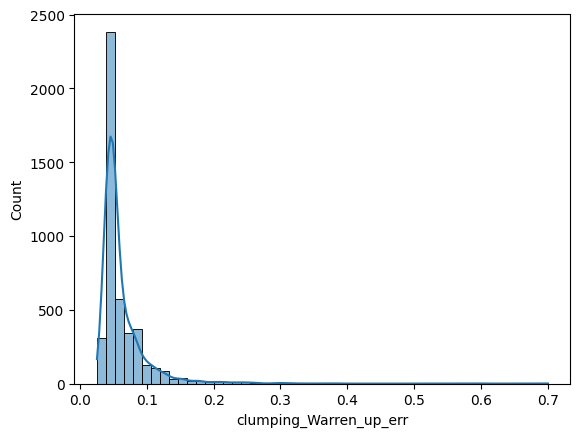

In [ ]:
sns.histplot(df_insitu['clumping_Warren_up_err'], kde=True, bins=50);

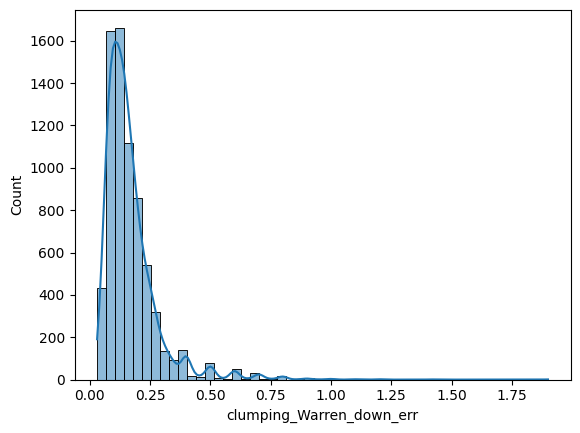

In [ ]:
sns.histplot(df_insitu['clumping_Warren_down_err'], kde=True, bins=50);

In [ ]:
df_insitu.loc[df_insitu['clumping_Warren_up_err'] >= 0.1,'LAI_Warren_up'] = np.nan
df_insitu.loc[df_insitu['clumping_Warren_down_err'] >= 0.35, 'LAI_Warren_down'] = np.nan

Definimos las **quality flags** especificas para las medidas del método Warren ('Warren_up_flag','Warren_down_flag').  
Nos basamos en las quality flags generales ('up_flag' y 'down_flag').

In [ ]:
df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].notnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), ['Warren_up_flag','Warren_down_flag']] = 0

df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].isnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_down_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].isnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_up_flag'] = 0

df_insitu.loc[df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].notnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_up_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].notnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_down_flag'] = 0


df_insitu.loc[(df_insitu['up_flag'] == 0) & df_insitu['down_flag'].isnull(), 'Warren_down_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & (df_insitu['up_flag'] == 0) & df_insitu['down_flag'].isnull(), 'Warren_up_flag'] = 0

df_insitu.loc[df_insitu['up_flag'].isnull() & (df_insitu['down_flag'] == 0), 'Warren_up_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_down'].notnull() & df_insitu['up_flag'].isnull() & df_insitu['down_flag'] == 0, 'Warren_down_flag'] = 0

**Calculamos el LAI y su error** en base a las quality flags. 

In [ ]:
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & (df_insitu['Warren_down_flag'] == 0), 'LAI_Warren'] = df_insitu['LAI_Warren_up'] + df_insitu['LAI_Warren_down']
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & (df_insitu['Warren_down_flag'] == 0), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err'] + df_insitu['LAI_Warren_down_err'] 


df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & df_insitu['Warren_down_flag'].isnull(), 'LAI_Warren'] = df_insitu['LAI_Warren_up']
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & df_insitu['Warren_down_flag'].isnull(), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err']


df_insitu.loc[df_insitu['Warren_up_flag'].isnull() & (df_insitu['Warren_down_flag'] == 0), 'LAI_Warren'] = df_insitu['LAI_Warren_down']
df_insitu.loc[df_insitu['Warren_up_flag'].isnull() & (df_insitu['Warren_down_flag'] == 0), 'LAI_Warren_err'] = df_insitu['LAI_Warren_down_err']


print(df_insitu['LAI_Warren'].isna().sum())

716


**Unificamos** en una sola clase 'Evergreen Needleleaf' y 'Evergreen Needleleaf Forest'.  
También 'Deciduous Broadleaf' y 'Deciduous Broadleaf Forest'.

In [ ]:
df_insitu.loc[df_insitu['IGBP_class'] == 'Evergreen Needleleaf Forest', 'IGBP_class'] = 'Evergreen Needleleaf'
df_insitu.loc[df_insitu['IGBP_class'] == 'Deciduous Broadleaf Forest', 'IGBP_class'] = 'Deciduous Broadleaf'

Nos quedamos con el LAI de las clases **forest** solo cuando tiene ambas medidas (LAI up y LAI down).

In [ ]:
# Primero definimos las clases que forman parte de forest. 
class_forest = ['Mixed Forest', 'Evergreen Needleleaf', 'Evergreen Broadleaf', 'Deciduous Broadleaf']

In [ ]:
# Descartamos filas cuando falta la medida de up
df_insitu = df_insitu.loc[~((df_insitu['Warren_up_flag'] == 0) & df_insitu['Warren_down_flag'].isnull() & (df_insitu['IGBP_class'].isin(class_forest)))]
# Descartamos filas cuando falta la medida de down
df_insitu = df_insitu.loc[~(df_insitu['Warren_up_flag'].isnull() & (df_insitu['Warren_down_flag'] == 0) & (df_insitu['IGBP_class'].isin(class_forest)))]

Eliminamos filas con **errores** más altos de LAI.

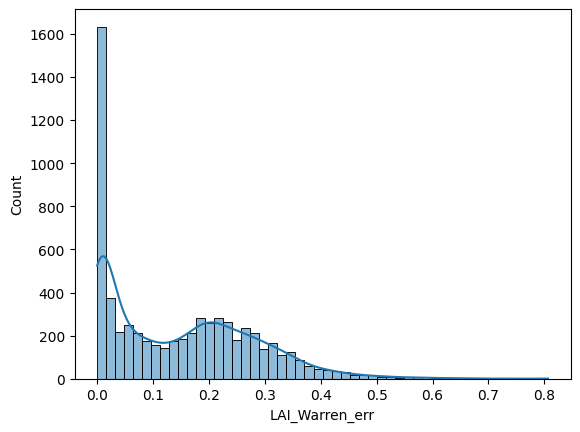

In [ ]:
sns.histplot(df_insitu['LAI_Warren_err'], kde=True, bins=50);

In [ ]:
# Descartamos medidas con errores mas altos
df_insitu = df_insitu[df_insitu['LAI_Warren_err'] <= 0.45]

In [ ]:
len(df_insitu)

6269

In [ ]:
# Eliminamos las filas donde el LAI es nulo
df_insitu.dropna(subset=['LAI_Warren'], inplace=True)
len(df_insitu)

5884

Eliminamos **valores anómalos** de LAI según la cubierta.

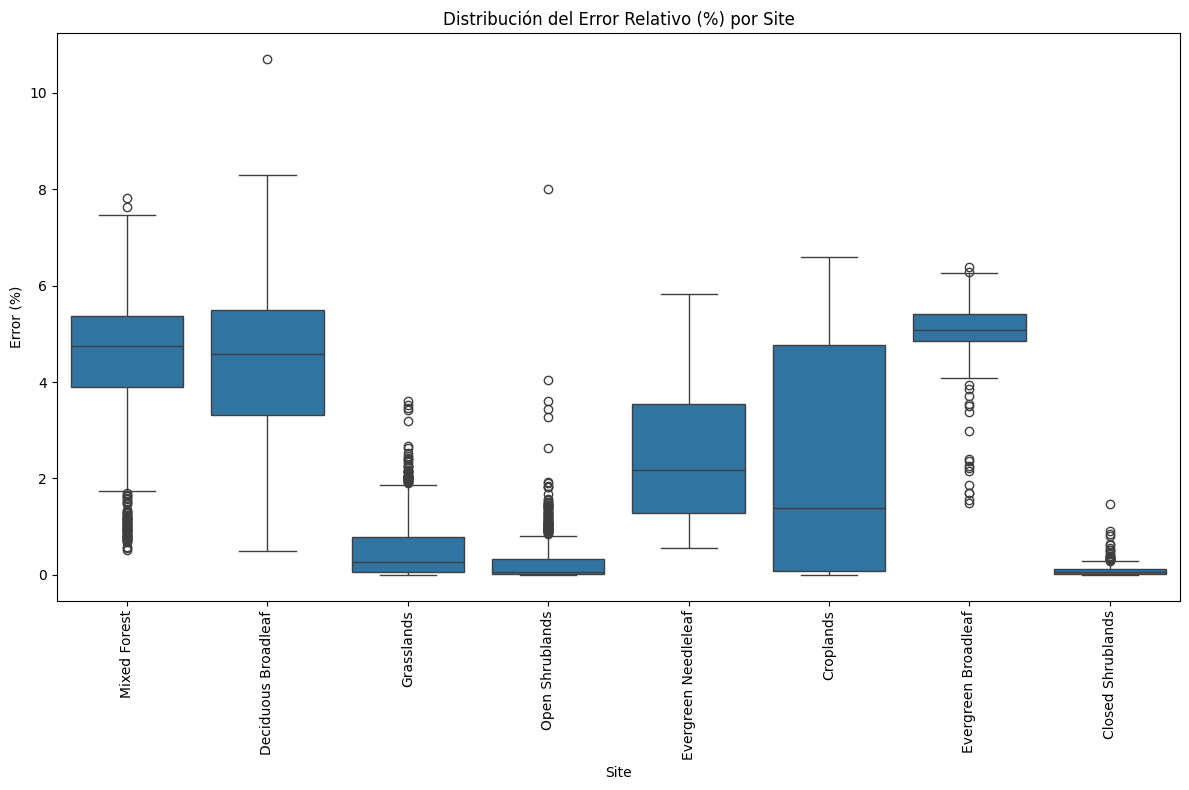

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df_insitu, x='IGBP_class', y='LAI_Warren')
plt.xticks(rotation=90)
plt.title('Distribución del Error Relativo (%) por Site')
plt.ylabel('Error (%)')
plt.xlabel('Site')
plt.tight_layout()
plt.show()

In [ ]:
len(df_insitu)

5884

In [ ]:
lai_max_cover = {
    'Mixed Forest': 7.5,
    'Evergreen Needleleaf': 8.0,
    'Open Shrublands': 5.0,
    'Croplands': 6.0,
    'Grasslands': 5.0,
    'Evergreen Broadleaf': 7.0,
    'Closed Shrublands': 5.0,
    'Deciduous Broadleaf': 7.0
}

for land_cover, lai_max in lai_max_cover.items():
    df_insitu = df_insitu[~((df_insitu['IGBP_class'] == land_cover) & (df_insitu['LAI_Warren'] > lai_max))]

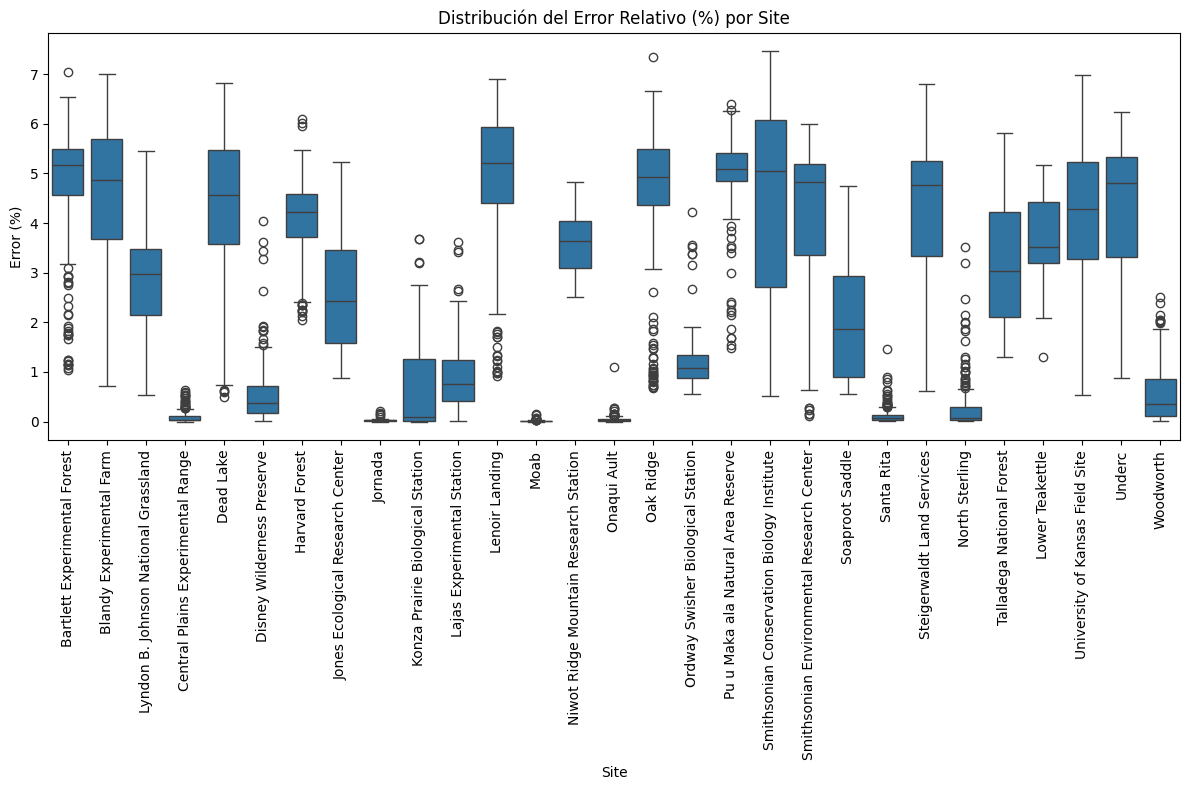

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df_insitu, x='Site', y='LAI_Warren')
plt.xticks(rotation=90)
plt.title('Distribución del Error Relativo (%) por Site')
plt.ylabel('Error (%)')
plt.xlabel('Site')
plt.tight_layout()
plt.show()

In [ ]:
len(df_insitu)

5853

Eliminamos **valores anómalos** de LAI según el site.

In [ ]:
lai_max_site ={
 'Harvard Forest':6.0,
 'Jones Ecological Research Center':5.5,
 'Jornada':0.04,
 'Konza Prairie Biological Station':3.0,
 'Lajas Experimental Station': 2.5,
 'Lenoir Landing':7.0,
 'Moab':0.2,
 'Niwot Ridge Mountain Research Station':5.0,
 'Onaqui Ault':0.2,
 'Oak Ridge':7.5,
 'Ordway Swisher Biological Station':2.0,
 'Pu u Maka ala Natural Area Reserve':7.0,
 'Smithsonian Conservation Biology Institute':8.0,
 'Smithsonian Environmental Research Center':6.0,
 'Soaproot Saddle':2.0,
 'Santa Rita':0.3,
 'Steigerwaldt Land Services':7.0,
 'North Sterling':0.6,
 'Talladega National Forest':6.0,
 'Lower Teakettle':5.5,
 'University of Kansas Field Site':7.0,
 'Underc':6.5,
 'Woodworth':2.0,
 'Bartlett Experimental Forest':6.5,
 'Blandy Experimental Farm':7.0,
 'Lyndon B. Johnson National Grassland':6.0,
 'Central Plains Experimental Range':0.25,
 'Dead Lake':7.0,
 'Disney Wilderness Preserve':1.5}

for site, lai_max in lai_max_site.items():
    df_insitu = df_insitu[~((df_insitu['Site'] == site) & (df_insitu['LAI_Warren'] > lai_max))]

In [ ]:
len(df_insitu)

5709

In [ ]:
lai_min_site ={
 'Harvard Forest':2.2,
 'Lenoir Landing':2.0,
 'Oak Ridge':2.5,
 'Bartlett Experimental Forest':3.0,
 'Dead Lake':0.6}

for site, lai_min in lai_min_site.items():
    df_insitu = df_insitu[~((df_insitu['Site'] == site) & (df_insitu['LAI_Warren'] < lai_min))]

In [ ]:
len(df_insitu)

5632

Quitamos el **dato UTC** a la columna fecha para estandarizarla con el dataset de satelite.

In [ ]:
df_insitu[['Site','TIME_IS']].head(2)

,Site,TIME_IS
0,Bartlett Experimental Forest,2022-07-19 19:07:00+00:00
1,Bartlett Experimental Forest,2022-07-20 05:43:00+00:00


In [ ]:
df_insitu['TIME_IS'] = pd.to_datetime(df_insitu['TIME_IS']).dt.tz_localize(None)
df_insitu[['Site','TIME_IS']].head(2)

,Site,TIME_IS
0,Bartlett Experimental Forest,2022-07-19 19:07:00
1,Bartlett Experimental Forest,2022-07-20 05:43:00


Visualizamos la **información** del dataset para  ver como queda.

In [ ]:
df_insitu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5632 entries, 0 to 9405
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   GBOV_ID                   5632 non-null   object        
 1   Site                      5632 non-null   object        
 2   GROUND_DATA_PI            5560 non-null   object        
 3   GROUND_DATA_PIs_Email     5560 non-null   object        
 4   GBOV_Email                5632 non-null   object        
 5   Network                   5632 non-null   object        
 6   Elevation                 5632 non-null   int64         
 7   IGBP_class                5632 non-null   object        
 8   Lat_IS                    5632 non-null   float64       
 9   Lon_IS                    5632 non-null   float64       
 10  TIME_IS                   5632 non-null   datetime64[ns]
 11  Version                   5632 non-null   float64       
 12  up_flag                  

### 3. Combinación de los datasets

**Merge de data sets**. Para cada site identificamos las medidas in_situ mas cercanas a la fecha de adquisicion del satélite

In [ ]:
df_list = []
days_diff_max = 5 # Diferencia maxima (en días) entre la medida de satelite y la medida in situ

# Itera sobre cada coordenada
for site, lat, lon in coords:
    # Filtra el DataFrame de df_insitu y df_sat según el 'Site'
    df_insitu_site = df_insitu[df_insitu['Site'] == site].copy()
    df_sat_site = df_sat[df_sat['Site_sat'] == site].copy()

    rows = []

    # Itera sobre los datos de satélite y sobre los datos in situ
    for index_sat, date_sat in df_sat_site['time'].items():
        for index_insitu, date_insitu in df_insitu_site['TIME_IS'].items():
            # Calcula la diferencia en días entre las fechas
            dif = (date_insitu - date_sat) / np.timedelta64(1, 'D')

            if abs(dif) <= days_diff_max: # Si la diferencia en dias es menor...
                # Crea una lista con la fila combinada de ambas fuentes de datos
                row = list(df_sat_site.loc[index_sat]) + list(df_insitu_site.loc[index_insitu])
                rows.append(row)

    # Si se encontraron filas, procesa los datos
    if rows:
        # Crear el DataFrame con las filas acumuladas
        df_cross_site = pd.DataFrame(rows, columns=list(df_sat_site.columns) + list(df_insitu_site.columns))

        # Añadir una columna 'delta' con la diferencia en tiempo entre el satélite y las mediciones in situ
        df_cross_site['delta'] = abs(df_cross_site['time'] - df_cross_site['TIME_IS'])

        # Añadir las fechas separadas de 'date_sat' y 'date_insitu'
        df_cross_site['date_sat'] = df_cross_site['time'].dt.date
        df_cross_site['date_insitu'] = df_cross_site['TIME_IS'].dt.date

        # Ordenar y eliminar duplicados por 'date_insitu'
        df_cross_site = df_cross_site.sort_values(by=['date_insitu', 'delta']).drop_duplicates(subset='date_insitu', keep='first')

        # Ordenar y eliminar duplicados por 'date_sat'
        df_cross_site = df_cross_site.sort_values(by=['date_sat', 'delta']).drop_duplicates(subset='date_sat', keep='first')


        # Agregar el DataFrame de este sitio a la lista
        df_list.append(df_cross_site)

# Combinar todos los DataFrames en uno solo
df_cross = pd.concat(df_list, axis=0, ignore_index=True)

Vemos el resultado del dataset combinado (solo algunas columnas)

In [ ]:
df_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   id                        818 non-null    object         
 1   longitude                 818 non-null    float64        
 2   latitude                  818 non-null    float64        
 3   time                      818 non-null    datetime64[ns] 
 4   B2                        818 non-null    float64        
 5   B3                        818 non-null    float64        
 6   B4                        818 non-null    float64        
 7   B5                        818 non-null    float64        
 8   B6                        818 non-null    float64        
 9   B7                        818 non-null    float64        
 10  B8                        818 non-null    float64        
 11  B8A                       818 non-null    float64        
 12  B11     

In [ ]:
df_cross[['date_sat','date_insitu','longitude','latitude','B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12','LAI_Warren']].head(5)

,date_sat,date_insitu,longitude,latitude,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,LAI_Warren
0,2019-06-07,2019-06-04,-72.171458,42.537834,0.0198,0.0532,0.0169,0.0982,0.3507,0.4087,0.4433,0.4232,0.1646,0.0673,4.030
1,2019-06-27,2019-07-02,-72.171458,42.537834,0.0236,0.0405,0.0193,0.0782,0.3244,0.4116,0.4295,0.4490,0.1786,0.0718,4.820
2,2019-07-12,2019-07-16,-72.171458,42.537834,0.0197,0.0203,0.0126,0.0247,0.0888,0.1154,0.0948,0.1156,0.0293,0.0117,3.871
3,2019-08-01,2019-07-30,-72.171458,42.537834,0.0176,0.0422,0.0188,0.0757,0.3112,0.3827,0.3980,0.3963,0.1670,0.0656,4.220
4,2019-08-26,2019-08-27,-72.171458,42.537834,0.0204,0.0405,0.0182,0.0711,0.2746,0.3450,0.3710,0.3663,0.1580,0.0626,4.281


In [ ]:
#df_cross = df_cross.sort_values(by = ['Site','time']).reset_index(drop=True) # Reordenamos por Site y time del satelite
df_cross[['Site','date_sat','date_insitu','delta']]

,Site,date_sat,date_insitu,delta
0,Harvard Forest,2019-06-07,2019-06-04,3 days 10:17:23
1,Harvard Forest,2019-06-27,2019-07-02,4 days 13:44:37
2,Harvard Forest,2019-07-12,2019-07-16,3 days 13:53:39.569000
3,Harvard Forest,2019-08-01,2019-07-30,2 days 09:45:19.875000
4,Harvard Forest,2019-08-26,2019-08-27,0 days 14:23:40.257000
...,...,...,...,...
813,Disney Wilderness Preserve,2023-08-11,2023-08-08,3 days 04:05:34.663000
814,Disney Wilderness Preserve,2023-08-21,2023-08-22,0 days 18:58:26.181000
815,Disney Wilderness Preserve,2023-09-20,2023-09-18,2 days 01:48:32.699000
816,Disney Wilderness Preserve,2023-10-05,2023-10-03,2 days 00:55:30.152000


In [ ]:
df_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   id                        818 non-null    object         
 1   longitude                 818 non-null    float64        
 2   latitude                  818 non-null    float64        
 3   time                      818 non-null    datetime64[ns] 
 4   B2                        818 non-null    float64        
 5   B3                        818 non-null    float64        
 6   B4                        818 non-null    float64        
 7   B5                        818 non-null    float64        
 8   B6                        818 non-null    float64        
 9   B7                        818 non-null    float64        
 10  B8                        818 non-null    float64        
 11  B8A                       818 non-null    float64        
 12  B11     

Graficamos espectros de vegetación correspondientes a diferentes valores de LAI

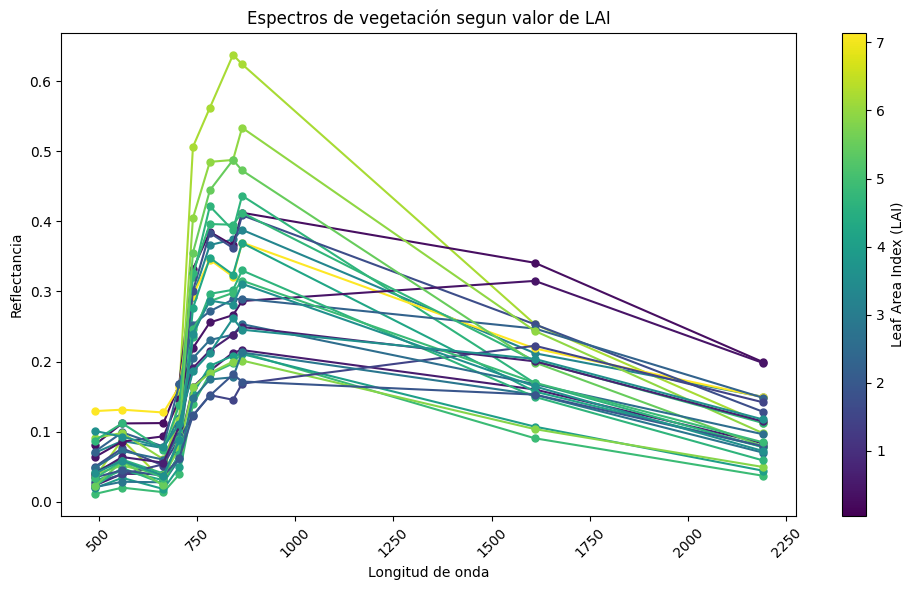

In [ ]:
# Graficar diferentes espectros
fig, ax = plt.subplots(figsize=(10, 6))

# Crear una lista de colores basada en el valor de LAI
cmap = plt.get_cmap('viridis')  # Elegir un mapa de colores
norm = plt.Normalize(df_cross['LAI_Warren'].min(), df_cross['LAI_Warren'].max())  # Normalizar el rango del LAI

for index, row in df_cross.sample(25).iterrows():
    # Obtener el valor del LAI para esta fila
    lai_value = row['LAI_Warren']

    # Mapear el valor de LAI a un color
    color = cmap(norm(lai_value))  # Obtener el color correspondiente al LAI

    # Graficar el espectro, usando el valor del LAI como color de la línea
    ax.plot([central_wl[band] for band in bandas], row[bandas], label=row['date_sat'].strftime('%Y-%m-%d'),
             marker='o', linestyle='-', markersize=5, color=color)

# Añadir barra de colores para mostrar la escala del LAI
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para la barra de colores
fig.colorbar(sm, ax=ax, label='Leaf Area Index (LAI)') # Associate colorbar with the axes

# Configuración del gráfico
ax.set_title("Espectros de vegetación segun valor de LAI") # Use ax.set_title instead of plt.title
ax.set_xlabel("Longitud de onda") # Use ax.set_xlabel instead of plt.xlabel
ax.set_ylabel("Reflectancia") # Use ax.set_ylabel instead of plt.ylabel

# Mostrar gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas de las bandas
plt.tight_layout()  # Ajustar el espacio
plt.show()

Nos quedamos con los datos del 2017 al 2022. Reservamos los del 2023 para test final.

In [ ]:
test_set = df_cross[pd.to_datetime(df_cross['date_insitu']) > pd.to_datetime('2023-01-01')]

In [ ]:
df_cross = df_cross[pd.to_datetime(df_cross['date_insitu']) < pd.to_datetime('2023-01-01')]

Exportamos el dataframe a un archivo csv (opcional).

In [ ]:
#df_cross.to_csv(drive_path + 'Sentinel2_SR_NEON_USA_LAI_2017_2023.csv')

### 4. Mini EDA

Verificamos si hay nulos en las bandas y en el target. Y los eliminamos.

In [ ]:
print(df_cross[bandas].isna().sum())
print('\nTarget:',df_cross['LAI_Warren'].isna().sum())
df_cross.dropna(subset=bandas, how='any', inplace=True)
df_cross.dropna(subset='LAI_Warren', inplace=True)

B2     0
B3     0
B4     0
B5     0
B6     0
B7     0
B8     0
B8A    0
B11    0
B12    0
dtype: int64

Target: 0


Definimos variables a excluir

In [ ]:
features_sel = ['Site',
 'Lat_IS',
 'Lon_IS',
 'date_sat',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B11',
 'B12',
 'NDVI',
 'Network',
 'Elevation',
 'IGBP_class',
 'date_insitu',
 'delta',
 'LAIe_Miller',
 'LAIe_Miller_err']

In [ ]:
df_cross['date_insitu'].max()

datetime.date(2022, 12, 29)

#### Dividimos en train y test 

**Estratificamos** por la variable 'IGBP_class' que corresponde a los tipos de cubierta de vegetación.

In [ ]:
train_set, val_set = train_test_split(df_cross, test_size=0.2, stratify=df_cross['IGBP_class'] ,random_state=42)
print(len(train_set))
print(len(val_set))

572
144


Vemos los tamaños de los datasets

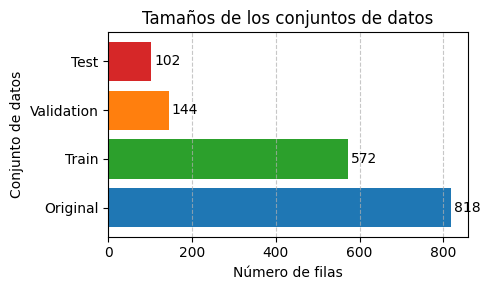

In [ ]:
# Tamaños de los datasets
sizes = {
    'Original': len(df_cross) + len(test_set),
    'Train': len(train_set),
    'Validation': len(val_set),
    'Test': len(test_set)
}

# Crear gráfico horizontal
plt.figure(figsize=(5, 3))
bars = plt.barh(list(sizes.keys()), list(sizes.values()), color=['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728'])

# Agregar etiquetas con el número de filas
for bar in bars:
    width = bar.get_width()
    plt.text(width + max(sizes.values()) * 0.01, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center')

plt.title('Tamaños de los conjuntos de datos')
plt.xlabel('Número de filas')
plt.ylabel('Conjunto de datos')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Definimos el target y vemos su distribución

Nuestra **variable objetivo** es el Leaf Area Index correspondiente al método Warren.

In [ ]:
target = 'LAI_Warren'

Vemos la **distribución** de la variable objetivo.  
Lamentablemente no tiene una distribución gausiana, lo que puede afectar a algunos modelos como el de regresion lineal.

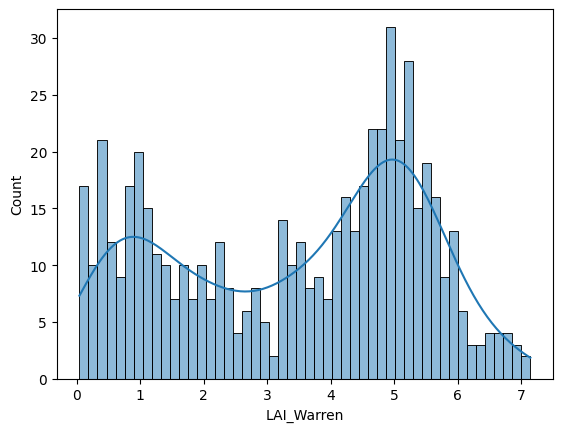

In [ ]:
sns.histplot(x= target, data = train_set, kde = True, bins=50);

#### Comprensión de variables

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 572 entries, 442 to 591
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   id                        572 non-null    object         
 1   longitude                 572 non-null    float64        
 2   latitude                  572 non-null    float64        
 3   time                      572 non-null    datetime64[ns] 
 4   B2                        572 non-null    float64        
 5   B3                        572 non-null    float64        
 6   B4                        572 non-null    float64        
 7   B5                        572 non-null    float64        
 8   B6                        572 non-null    float64        
 9   B7                        572 non-null    float64        
 10  B8                        572 non-null    float64        
 11  B8A                       572 non-null    float64        
 12  B11        

#### Feature reduction preliminar

De todas las features nos quedamos solo con las bandas del satélite, pues no queremos que nuestro modelo dependa de datos de coordenadas, fecha, clase de cubierta.  
Es decir, debemos ser capaces de predecir el LAI a partir solo de los espectros. 

Seleccionamos las 10 bandas de interés:

In [ ]:
features = bandas
features

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

#### Nulos y duplicados

Verificamos si hay nulos en las bandas y en el target. Y los eliminamos.

In [ ]:
print(train_set[bandas].isna().sum())
print('Target:',train_set['LAI_Warren'].isna().sum())
#train_set.dropna(subset=bandas, how='any', inplace=True)
#train_set.dropna(subset='LAI_Warren', inplace=True)
print('\n')

print(val_set[bandas].isna().sum())
print('Target:',val_set['LAI_Warren'].isna().sum())
#val_set.dropna(subset=bandas, how='any', inplace=True)
#val_set.dropna(subset='LAI_Warren', inplace=True)

B2     0
B3     0
B4     0
B5     0
B6     0
B7     0
B8     0
B8A    0
B11    0
B12    0
dtype: int64
Target: 0


B2     0
B3     0
B4     0
B5     0
B6     0
B7     0
B8     0
B8A    0
B11    0
B12    0
dtype: int64
Target: 0


Verificamos si hay duplicados

In [ ]:
print(train_set.duplicated(subset=bandas, keep='first').sum())
print(val_set.duplicated(subset=bandas, keep='first').sum())

0
0


#### Miramos los outliers

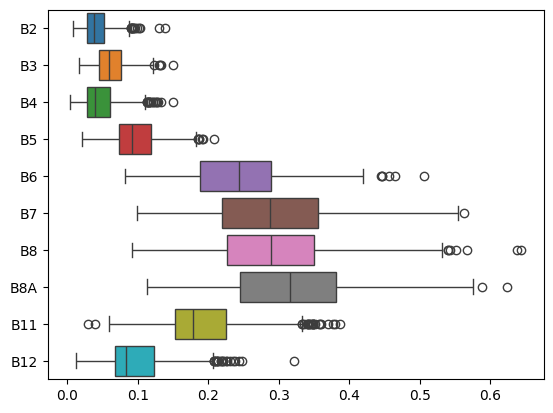

In [ ]:
sns.boxplot(data = train_set[features], orient = "h");

### Preparacion de features

#### Definimos X_train, y_train

In [ ]:
X_train = train_set[features]
y_train = train_set[target]

X_val = val_set[features]
y_val = val_set[target]

#### Escalamos las features numericas (bandas) con un standar escalar. Necesario para modelos como la regresión lineal.

In [ ]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[bandas]), columns=bandas)
X_val_scaled = pd.DataFrame(scaler.transform(X_val[bandas]), columns=bandas)

### Modelo base

#### Instanciamos y entrenamos una Linear regression

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled,y_train)


LinearRegression()

Resultados para **train**

In [ ]:
y_pred = lin_reg.predict(X_train_scaled)

In [ ]:
argumentos = (y_train, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_train_scaled, y_train))

MSE: 1.0937999512751246
RMSE: 1.0458489141721785
MAE: 0.8302198429003899
MAPE: 0.7578461638553309
R2: 0.7127245564690777


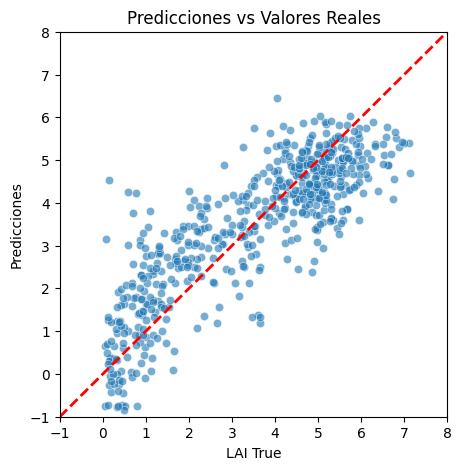

In [ ]:
# Crear el gráfico de dispersión
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_train, y=y_pred, alpha=0.6)
plt.plot([-1, 8], [-1, 8], 'r--', lw=2)
plt.xlabel('LAI True')
plt.ylabel('Predicciones')
plt.ylim(-1,8)
plt.xlim(-1,8)
plt.title('Predicciones vs Valores Reales')
plt.show()

Resultados para **val**

In [ ]:
y_pred = lin_reg.predict(X_val_scaled)

argumentos = (y_val, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_val_scaled, y_val))

MSE: 0.8798229779564928
RMSE: 0.9379887941529433
MAE: 0.7510669916920946
MAPE: 0.49616012145034283
R2: 0.7521260988863168


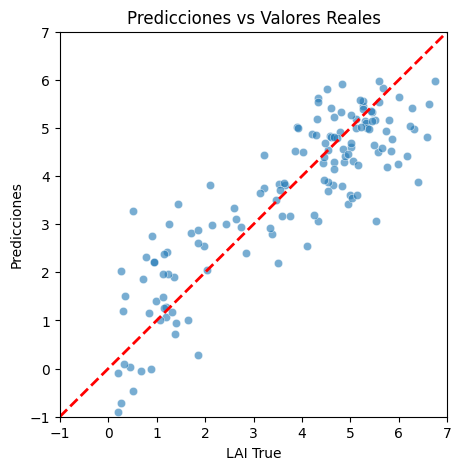

In [ ]:
# Crear el gráfico de dispersión
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.6)
plt.plot([-1, 8], [-1, 8], 'r--', lw=2)
plt.xlabel('LAI True')
plt.ylabel('Predicciones')
plt.ylim(-1,7)
plt.xlim(-1,7)
plt.title('Predicciones vs Valores Reales')
plt.show()

### Feature reduction

a) Selección de las mejores features con **análisis visual**

Aplicamos el test de significación de la correlación de Pearson, acudiendo a Scipy.  
Vemos que para todas las bandas pvalue  tien un  nivel de significacion deseado menor que 1. Lo que nos lleva a aceptar la hipotesis alternativa de que existe correlación significativa entre las features.

In [ ]:
for col in bandas:
    print(col)
    print(pearsonr(train_set["LAI_Warren"], train_set[col]))

B2
PearsonRResult(statistic=-0.3825898860961298, pvalue=2.2278492844231153e-21)
B3
PearsonRResult(statistic=-0.42675021609767694, pvalue=1.0173469832822374e-26)
B4
PearsonRResult(statistic=-0.6452286105558986, pvalue=1.1826888344992371e-68)
B5
PearsonRResult(statistic=-0.5355154256093089, pvalue=9.17135443907976e-44)
B6
PearsonRResult(statistic=0.20311123797372965, pvalue=9.670121252917548e-07)
B7
PearsonRResult(statistic=0.2681915138687175, pvalue=7.031028755634283e-11)
B8
PearsonRResult(statistic=0.25583126685476193, pvalue=5.338177457126531e-10)
B8A
PearsonRResult(statistic=0.24782615744724854, pvalue=1.8765373184484824e-09)
B11
PearsonRResult(statistic=-0.6156612364792347, pvalue=5.7097358662266014e-61)
B12
PearsonRResult(statistic=-0.7187497698737786, pvalue=4.938619923599228e-92)


Vemos las features (bandas) mas correlacionadas con el target usando el metodo de Pandas corr que calcula el coeficiente de correlación de Pearson.  
Vemos que las bandas mas correlacionadas con el target son  las B12, B4, B11 y B5. Y las que menos la B6, B8A, B8 y B7.

In [ ]:
corr = train_set[features + [target]].corr()
np.abs(corr[target].sort_values(ascending = False))

LAI_Warren    1.000000
B7            0.268192
B8            0.255831
B8A           0.247826
B6            0.203111
B2            0.382590
B3            0.426750
B5            0.535515
B11           0.615661
B4            0.645229
B12           0.718750
Name: LAI_Warren, dtype: float64

<Axes: >

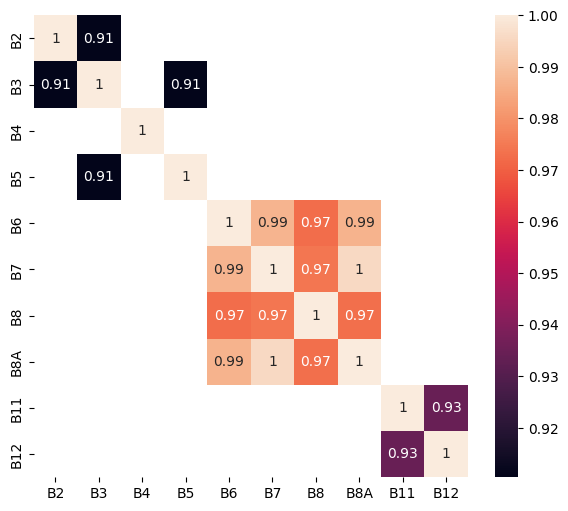

In [ ]:
corr = train_set[features].corr()
high_corr = corr[abs(corr) > 0.9]
plt.figure(figsize=(7,6))
sns.heatmap(abs(high_corr), annot=True)

La más alta correlación entre bandas es:  
B7-B8A del 100%.  
B6-B7 del 99%.  
B6-B8A del 99%.  
B7-B8 del 98%.  
B6-B8 del 97%.  
B8-B8A del 97%.


Descarto B8A, B6, B7 que tienen una alta correlacion y son las que menos correlación tienen con el target.  
También descarto B3 porque tiene alto correlación con B2 y B5.

In [ ]:
bandas_eliminar = ['B6','B8A', 'B7', 'B3']
bandas_sel = [banda for banda in bandas if banda not in bandas_eliminar]
bandas_sel

['B2', 'B4', 'B5', 'B8', 'B11', 'B12']

In [ ]:
X_train_visual = X_train[bandas_sel]
X_train_scaled_visual = X_train_scaled[bandas_sel]
X_train_scaled_visual.columns.to_list()

['B2', 'B4', 'B5', 'B8', 'B11', 'B12']

In [ ]:
X = X_train[features]
Y = y_train

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X, Y)

names = X.columns
scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
feat_score = pd.DataFrame(scores, columns=['Score', 'Feature'])
feat_score

,Score,Feature
0,0.5901,B12
1,0.0962,B11
2,0.0710,B7
3,0.0627,B8A
4,0.0429,B2
5,0.0319,B5
6,0.0289,B6
7,0.0278,B4
8,0.0265,B3
9,0.0220,B8


In [ ]:
X_train_selector = X_train[['B2','B5','B7','B8A','B11','B12']]
X_train_scaled_selector = X_train_scaled[['B2','B5','B7','B8A','B11','B12']]
X_train_scaled_selector.columns.to_list()

['B2', 'B5', 'B7', 'B8A', 'B11', 'B12']

b) Selección de las mejores features usando un **modelo intermedio**

Selección de las mejores features a través de un modelo intermedio (usando **SelectFromModel**).  
Seleccionamos las bandas que queden con una importancia por encima de la mediana.

c) Selección de las mejores features empleando **RFE**

In [ ]:
rf_RFE = RandomForestRegressor(max_depth=5, random_state= 42)

rfe = RFE(estimator = rf_RFE,
          n_features_to_select= 6, # Iterará hasta quedarse con 6
          step = 1) # Elimina de una en una, pero es configurable

rfe.fit(X_train, y_train)
print(rfe.ranking_)
pd.DataFrame(rfe.ranking_, columns= ["ranking"], index = X_train.columns).sort_values("ranking")

[1 3 5 2 1 1 4 1 1 1]


,ranking
B2,1
B6,1
B7,1
B8A,1
B11,1
B12,1
B5,2
B3,3
B8,4
B4,5


In [ ]:
X_train_rfe = pd.DataFrame(rfe.transform(X_train), columns = rfe.get_feature_names_out())
X_train_scaled_rfe = pd.DataFrame(rfe.transform(X_train_scaled), columns = rfe.get_feature_names_out())
X_train_rfe.columns.to_list()

['B2', 'B6', 'B7', 'B8A', 'B11', 'B12']

d) Selección de las mejores features empleando **SFS**

In [ ]:
rf_SFS = RandomForestRegressor(max_depth=5,random_state = 42)

sfs_forward = SequentialFeatureSelector(rf_SFS,
                                        n_features_to_select = 6,
                                        cv = 5,
                                        scoring = "neg_mean_absolute_percentage_error")


sfs_forward.fit(X_train, y_train)

SequentialFeatureSelector(estimator=RandomForestRegressor(max_depth=5,
                                                          random_state=42),
                          n_features_to_select=6,
                          scoring='neg_mean_absolute_percentage_error')

In [ ]:
X_train_sfs = pd.DataFrame(sfs_forward.transform(X_train), columns = sfs_forward.get_feature_names_out())
X_train_scaled_sfs = pd.DataFrame(sfs_forward.transform(X_train_scaled), columns = sfs_forward.get_feature_names_out())
X_train_sfs.columns.to_list()

['B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

Selección de las mejores features mediante un sistema de **hard-voting** aplicado a lo obtenido en los pasos 1 a 5 anteriores.

In [ ]:
# Unir todas las listas
all_features = X_train_selector.columns.to_list() + X_train_rfe.columns.to_list() + X_train_sfs.columns.to_list()

# Contar la frecuencia de cada feature
feature_counts = Counter(all_features)

# Ordenar las features por frecuencia
sorted_features = [feature for feature, count in feature_counts.most_common()]

# Mostrar la lista definitiva de features
print("Lista definitiva de features ordenadas por popularidad:")
sorted_features


Lista definitiva de features ordenadas por popularidad:


['B7', 'B8A', 'B11', 'B12', 'B2', 'B6', 'B5', 'B8']

In [ ]:
feature_counts

Counter({'B7': 3,
         'B8A': 3,
         'B11': 3,
         'B12': 3,
         'B2': 2,
         'B6': 2,
         'B5': 1,
         'B8': 1})

In [ ]:
X_train_hvote = X_train[['B2','B5','B7','B8A','B11','B12']]
X_train_scaled_hvote = X_train_scaled[['B2','B5','B7','B8A','B11','B12']]

### Probar varios modelos

Comparación de modelos y diferentes features selection con Validación Cruzada 

In [ ]:
model_names = ["Regresion Lineal","Ridge", "Lasso", "ElasticNet", "SVR","Random Forest","XGBoost","LightGBM","CatBoost"]

lr = LinearRegression()
ridgeR = Ridge(random_state=42)
lassoR = Lasso(alpha=0.01, random_state=42)
elastic_net = ElasticNet(alpha= 0.01, l1_ratio= 0.5, random_state=42)
rf = RandomForestRegressor(random_state= 42)
xgb = XGBRegressor(random_state = 42)
lgb = LGBMRegressor(random_state= 42, verbose = -100)
cat  = CatBoostRegressor(random_state= 42, verbose = False)
svr = SVR()

model_set = [lr, ridgeR, lassoR, elastic_net, svr, rf, xgb, lgb, cat]


metricas_cv = {}
valores = []
for nombre_modelo,modelo in zip(model_names, model_set):

    for nombre,set,set_scaled in zip(["Visual","SelectedFromModel", 'RFE', 'SFS','Hard voting',"Full_num_features"],[X_train_visual,  X_train_selector, X_train_rfe, X_train_sfs, X_train_hvote, X_train],[X_train_scaled_visual,  X_train_scaled_selector, X_train_scaled_rfe, X_train_scaled_sfs, X_train_scaled_hvote, X_train_scaled]):
        combinacion = nombre_modelo + "-" + nombre
        print(f"Para <{combinacion}> con <num_features: {len(set.columns.to_list())}>")
        print(modelo)
    
        if nombre_modelo not in ["Regresion Lineal", "Ridge", "Lasso", "ElasticNet", "SVR"]:
            metricas_cv[combinacion] = cross_val_score(modelo, set, y_train, cv = 3, scoring = "neg_mean_absolute_percentage_error")
        else:
            metricas_cv[combinacion] = cross_val_score(modelo, set_scaled, y_train, cv = 3, scoring = "neg_mean_absolute_percentage_error") 
        print(-np.mean(metricas_cv[combinacion]), "\n")
        valores.append(-np.mean(metricas_cv[combinacion]))
ganador = list(metricas_cv.keys())[np.argmin(valores)]
best_score = np.min(valores)

Para <Regresion Lineal-Visual> con <num_features: 6>
LinearRegression()
0.7851697781612179 

Para <Regresion Lineal-SelectedFromModel> con <num_features: 6>
LinearRegression()
0.7873594210452647 

Para <Regresion Lineal-RFE> con <num_features: 6>
LinearRegression()
0.7944206298679178 

Para <Regresion Lineal-SFS> con <num_features: 6>
LinearRegression()
0.7826584376881306 

Para <Regresion Lineal-Hard voting> con <num_features: 6>
LinearRegression()
0.7873594210452647 

Para <Regresion Lineal-Full_num_features> con <num_features: 10>
LinearRegression()
0.7609031510249565 

Para <Ridge-Visual> con <num_features: 6>
Ridge(random_state=42)
0.7848032910166262 

Para <Ridge-SelectedFromModel> con <num_features: 6>
Ridge(random_state=42)
0.7813171692373068 

Para <Ridge-RFE> con <num_features: 6>
Ridge(random_state=42)
0.7875839218338907 

Para <Ridge-SFS> con <num_features: 6>
Ridge(random_state=42)
0.7757251845615457 

Para <Ridge-Hard voting> con <num_features: 6>
Ridge(random_state=42)
0

In [ ]:
# Calcular la media de los valores
mean_values = {key: -np.mean(value) for key, value in metricas_cv.items()}

# Ordenar por media en orden descendente
sorted_mean_values = dict(sorted(mean_values.items(), key=lambda item: item[1]))

# Imprimir los resultados
for model, mean in sorted_mean_values.items():
    print(f"{model}: {mean:.2f}")

SVR-SFS: 0.56
CatBoost-SFS: 0.57
LightGBM-SFS: 0.58
SVR-SelectedFromModel: 0.58
SVR-Hard voting: 0.58
SVR-Full_num_features: 0.58
SVR-Visual: 0.59
SVR-RFE: 0.59
Random Forest-SFS: 0.59
Random Forest-SelectedFromModel: 0.61
Random Forest-Hard voting: 0.61
Random Forest-RFE: 0.61
XGBoost-SFS: 0.61
CatBoost-Full_num_features: 0.62
CatBoost-RFE: 0.62
Random Forest-Full_num_features: 0.62
LightGBM-RFE: 0.63
CatBoost-SelectedFromModel: 0.63
CatBoost-Hard voting: 0.63
Random Forest-Visual: 0.64
CatBoost-Visual: 0.64
LightGBM-SelectedFromModel: 0.65
LightGBM-Hard voting: 0.65
XGBoost-Full_num_features: 0.66
LightGBM-Full_num_features: 0.66
XGBoost-RFE: 0.66
LightGBM-Visual: 0.68
XGBoost-SelectedFromModel: 0.69
XGBoost-Hard voting: 0.69
XGBoost-Visual: 0.69
Ridge-Full_num_features: 0.76
ElasticNet-Full_num_features: 0.76
Regresion Lineal-Full_num_features: 0.76
Lasso-Full_num_features: 0.77
ElasticNet-SFS: 0.77
ElasticNet-SelectedFromModel: 0.78
ElasticNet-Hard voting: 0.78
Lasso-SFS: 0.78
Ridg

In [ ]:
print(f"El ganador es {ganador} con {best_score.round(4)}")

El ganador es SVR-SFS con 0.5633


En  principio, viendo la validación cruzada (**contra train**) se observa que usando la feature selection tenemos mejores resultados que usando todas las features.  
Y de los metodos el que ligeramente resalta es el SFS.   

Y claramente, de todos los modelos de ML, la regresion lineal y sus variantes (Ridge, Lasso y Elastic Net) muestran los peores resultados. 

El ganador es el **SVM-SFS**.

Pero antes hay que probar **contra test** a ver si mejora con respecto al modelo base.

In [ ]:
regr = SVR()
regr.fit(X_train_scaled_sfs, y_train)

y_pred = regr.predict(X_val_scaled[X_train_scaled_sfs.columns])

argumentos = (y_val, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', regr.score(X_val_scaled[X_train_scaled_sfs.columns], y_val))

MSE: 0.9429380648910389
RMSE: 0.9710499806348997
MAE: 0.6728310535561358
MAPE: 0.3319250713976053
R2: 0.7343445869122469


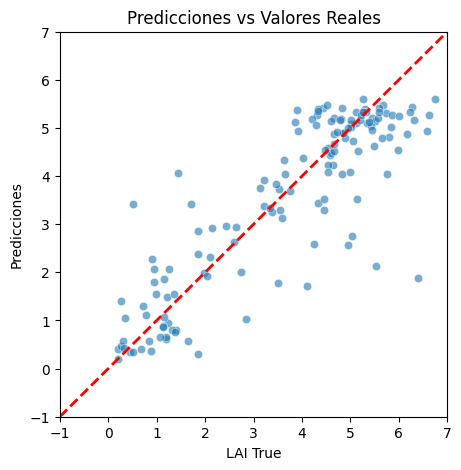

In [ ]:
# Crear el gráfico de dispersión
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.6)
plt.plot([-1, 7], [-1, 7], 'r--', lw=2)
plt.xlabel('LAI True')
plt.ylabel('Predicciones')
plt.ylim(-1,7)
plt.xlim(-1,7)
plt.title('Predicciones vs Valores Reales')
plt.show()

Efectivamente, el SVR con feature reduction SFS (MAPE: 0.5830) muestra mejor desempeño que el modelo base de linear regression (MAPE: 0.6841).  
Sin embargo, en términos de RMSE la regresión lineal (RMSE: 1.1350) muestra mejor resultado que el SVR (RMSE: 1.2015)

Nos quedaremos con el modelo de **regresion lineal** por ser más sencillo y porque considerando ambas métricas las diferencias no son muy determinantes.

No usaremos la feature selection ya que la regresion lineal mostró mejor desempeño usando **todas las features**.


### Modelo final

Usamos el modelo de regresion lineal con todas las bandas y graficamos las predicciones vs los valores reales, identificados por su tipo de cubierta.

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled,y_train)

LinearRegression()

In [ ]:
y_pred = lin_reg.predict(X_val_scaled)

argumentos = (y_val, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_val_scaled, y_val))

MSE: 0.8798229779564928
RMSE: 0.9379887941529433
MAE: 0.7510669916920946
MAPE: 0.49616012145034283
R2: 0.7521260988863168


Calculamos el uncertainty agreement ratio **(UAR)**, correspondiente a el porcentaje de estimaciones que caen dentro dentro de 1 unidad.

In [ ]:
# Variable para contar cuántos puntos de y_pred están dentro de 1 unidad
count = 0
# Iterar a través de los elementos de y_val y y_pred
for y_t, y_p in zip(y_val, y_pred):
    if abs(y_p - y_t) <= 1:
        count += 1

print(f"Cantidad de puntos estimados dentro de la unidad: {count}")
print(f"Cantidad total de puntos estimados: {len(y_val)}")

UAR = count/len(y_val)
print(f"UAR: {UAR:.4f}")

Cantidad de puntos estimados dentro de la unidad: 98
Cantidad total de puntos estimados: 144
UAR: 0.6806


Obtenemos la ecuacion de la regresión lineal

In [ ]:
# Obtener coeficientes e intercepto
coeficientes = lin_reg.coef_
intercepto = lin_reg.intercept_

# Mostrar la ecuación de la regresión lineal múltiple
ecuacion = f"y = {intercepto:.3f}"
for coef, feature in zip(coeficientes, lin_reg.feature_names_in_):
    ecuacion += f" + ({coef:.4f} * {feature})"

print(ecuacion)

y = 3.444 + (0.5420 * B2) + (-0.9988 * B3) + (0.7320 * B4) + (-0.3089 * B5) + (1.4246 * B6) + (-0.2934 * B7) + (-0.1231 * B8) + (0.6452 * B8A) + (-1.8111 * B11) + (-0.0342 * B12)


In [ ]:
df_result = pd.DataFrame(y_val)
df_result['pred'] = y_pred
df_result['Class'] = val_set['IGBP_class']

Graficamos la prediccion vs valor real por cubierta

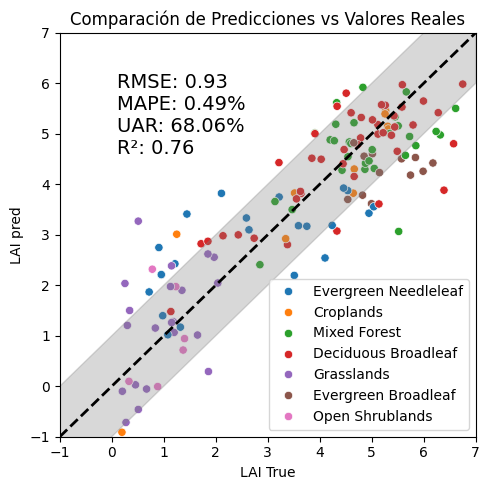

In [ ]:
# Crear figura
plt.figure(figsize=(5, 5))

# Scatter plot
sns.scatterplot(data=df_result, x="LAI_Warren", y="pred", hue="Class")

# Línea de identidad
x_vals = [-1, 7]
plt.plot(x_vals, x_vals, 'k--', lw=2)

# Sombra entre y = x - 1 y y = x + 1
plt.fill_between(x_vals,
                 [x - 1 for x in x_vals],
                 [x + 1 for x in x_vals],
                 color='gray', alpha=0.3)

plt.xlim(-1, 7)
plt.ylim(-1, 7)

plt.xlabel('LAI True')
plt.ylabel('LAI pred')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.legend()

# Métricas de evaluación
mse = 0.8627440902868396
rmse = 0.9288401855469215
mae = 0.7418094136413591
mape = 0.48795318488835693
r2 = 0.7562350517781432

# Texto de métricas en el gráfico
metric_text = (#f"MSE: {mse:.2f}\n"
               f"RMSE: {rmse:.2f}\n"
               #f"MAE: {mae:.2f}\n"
               f"MAPE: {mape:.2f}%\n"
               f"UAR: {UAR*100:.2f}%\n"
               f"R²: {r2:.2f}")

plt.text(0.1, 4.6, metric_text, fontsize=14)

plt.tight_layout()
plt.show()


### Analisis de errores

Calculamos los residuos y vemos su distribución.  
Se observa que los errores presentan una distribución normal, lo que es un buen indicativo para cualquier modelo.

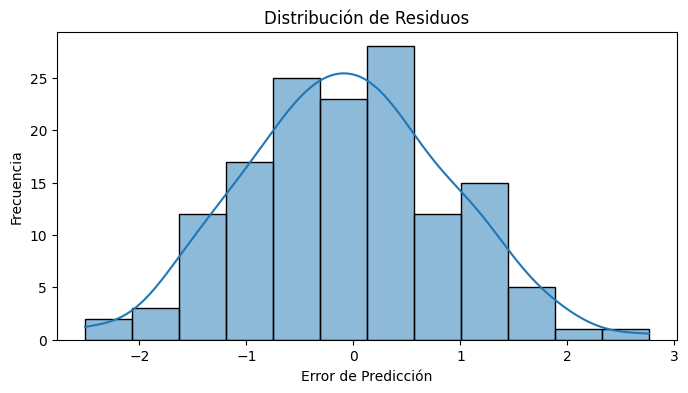

In [ ]:
# Calcular residuos
residuos = y_pred - y_val

# Visualización de residuos
plt.figure(figsize=(8, 4))
sns.histplot(residuos, kde=True)
plt.title('Distribución de Residuos'); plt.xlabel('Error de Predicción'); plt.ylabel('Frecuencia')
plt.show()

Graficamos los residuos versus el valor real para intentar ver patrones donde se concentran los errores.  
Se observa como la mayor cantidad de puntos más alejados del error 0 corresponden a los valores extremos de LAI (valores menores de 2 y valores mayores de 4).  
Mientras que los valores intermedios de LAI (2 a 4) presentan puntos más cercanos al cero.  
Es decir, donde menos falla el modelo es en los valores intermedios de LAI.  
Para  valores bajos de LAI el modelo tiende a sobreestimar y para los valores altos el modelo tiende a subestimar.

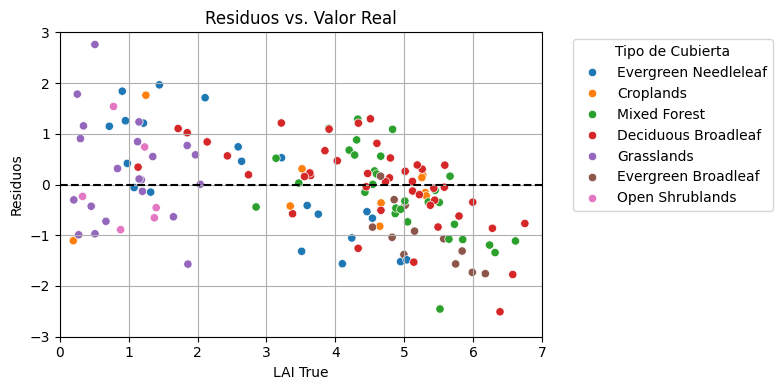

In [ ]:
df_residuos = pd.DataFrame({
    'Valor Real': y_val,
    'Residuos': residuos,
    'Clase de Cubierta': val_set['IGBP_class'].values
})

plt.figure(figsize=(8, 4))
sns.scatterplot(data=df_residuos, x='Valor Real', y='Residuos', hue='Clase de Cubierta', palette='tab10')

plt.axhline(y=0, color='k', linestyle='--')
plt.title('Residuos vs. Valor Real')
plt.xlabel('LAI True')
plt.ylabel('Residuos')
plt.ylim(-3,3)
plt.xlim(0,7)
# Leyenda fuera del gráfico
plt.legend(title='Tipo de Cubierta', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()


Como vemos en la grafica anterior y haciendo un levantamiento de los errores por tipo de cubierta, las clases que más salen del error de la 1 unidad son los bosques Evergreen y los que mejor cumplen son los Open Shrublands y los bosques Deciduous.

In [ ]:
# Filtrar los puntos con residuo absoluto mayor o igual a 1
residuos_grandes = val_set[abs(residuos) >= 1]

# Contar cuántos puntos hay por clase con residuo >= 1
conteo_residuos_grandes = residuos_grandes.groupby('IGBP_class').size()

# Contar el total de puntos por clase en el val_set
conteo_total = val_set.groupby('IGBP_class').size()

# Calcular el porcentaje
porcentaje = (conteo_residuos_grandes / conteo_total) * 100

# Mostrar el resultado
print(porcentaje.sort_values(ascending=False))


IGBP_class
Evergreen Broadleaf     58.333333
Evergreen Needleleaf    54.545455
Mixed Forest            30.000000
Grasslands              23.809524
Deciduous Broadleaf     23.255814
Croplands               20.000000
Open Shrublands         16.666667
dtype: float64


Haciendo un análisis más exhaustivo de los errores del modelo. Miramos la distribucion de los errores inherentes a las medidas de campo para ver si tienen un impacto en el desempeño final del modelo.  
Obsevando la distribucion de los errores de LAI_Warren y del clumpling en los siguientes boxplots vemos como la media se desplaza a la derecha para aquellos puntos que presentan residuos mayor que 1 en el modelo.  
Esto indica que se podría apurar más el umbral de filtrado para descartar las medidas con mayor error antes de entrenar el modelo.  
En este caso lo dejamos así porque no contamos con un dataset muy grande para descartar más puntos.

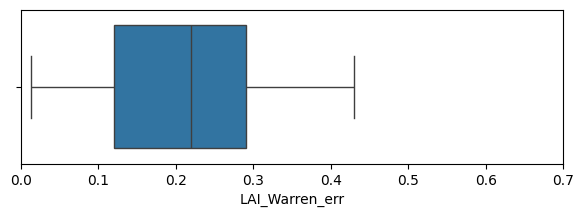

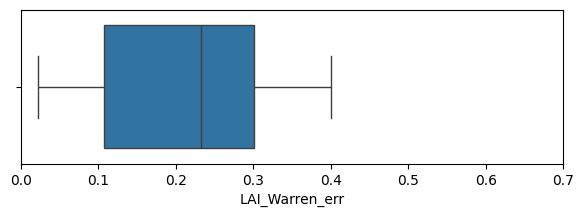

In [ ]:
plt.figure(figsize=(7,2))
sns.boxplot(data = val_set, x = 'LAI_Warren_err')
plt.xlim(left=0, right=0.7)
plt.show()

plt.figure(figsize=(7,2))
sns.boxplot(data = val_set[abs(residuos) >= 1], x ='LAI_Warren_err')
plt.xlim(left=0, right=0.7)
plt.show()

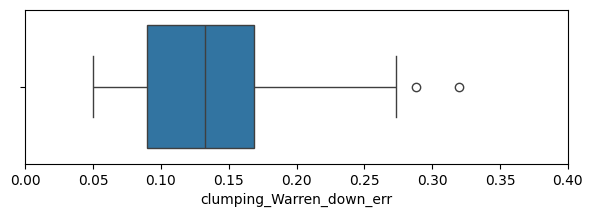

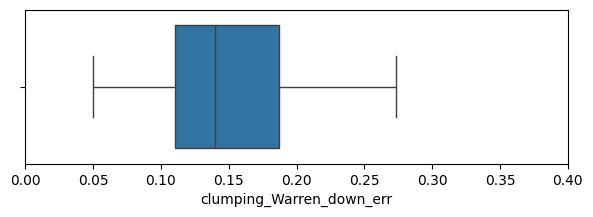

In [ ]:
plt.figure(figsize=(7,2))
sns.boxplot(data = val_set, x ='clumping_Warren_down_err')
plt.xlim(left=0, right=0.4)  # Limita el eje X hasta 7
plt.show()

plt.figure(figsize=(7,2))
sns.boxplot(data = val_set[abs(residuos) >= 1], x ='clumping_Warren_down_err')
plt.xlim(left=0, right=0.4)  # Limita el eje X hasta 7
plt.show()

In [ ]:
df_result['residuos'] = residuos

In [ ]:
df_result['Site'] = val_set.loc[residuos.index]['Site']

In [ ]:
df_result['LAI_error'] = val_set.loc[residuos.index]['LAI_Warren_err']

In [ ]:
df_result

,LAI_Warren,pred,Class,residuos,Site,LAI_error
63,2.640000,3.098432,Evergreen Needleleaf,0.458432,Jones Ecological Research Center,0.220000
70,1.446000,3.410846,Evergreen Needleleaf,1.964846,Jones Ecological Research Center,0.125000
388,3.517000,3.826668,Croplands,0.309668,Smithsonian Environmental Research Center,0.150000
62,1.215000,2.425597,Evergreen Needleleaf,1.210597,Jones Ecological Research Center,0.121000
18,4.544000,4.547741,Mixed Forest,0.003741,Harvard Forest,0.225000
...,...,...,...,...,...,...
485,2.110000,3.820886,Evergreen Needleleaf,1.710886,Talladega National Forest,0.200000
518,3.910006,5.001753,Deciduous Broadleaf,1.091747,University of Kansas Field Site,0.316975
154,2.040000,2.044493,Grasslands,0.004493,Lajas Experimental Station,0.100000
223,4.950000,4.462876,Mixed Forest,-0.487124,Oak Ridge,0.190000


### Prueba contra test

In [ ]:
X_test = test_set[bandas]
y_test = test_set[target]

In [ ]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=bandas)

In [ ]:
y_pred = lin_reg.predict(X_test_scaled)

argumentos = (y_test, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_test_scaled, y_test))

MSE: 1.0157924200830448
RMSE: 1.0078652787367193
MAE: 0.786474122837425
MAPE: 0.5890788550062166
R2: 0.7295110965990634


In [ ]:
# Variable para contar cuántos puntos de y_pred están dentro de 1 unidad
count = 0
# Iterar a través de los elementos de y_val y y_pred
for y_t, y_p in zip(y_test, y_pred):
    if abs(y_p - y_t) <= 1:
        count += 1

print(f"Cantidad de puntos estimados dentro de la unidad: {count}")
print(f"Cantidad total de puntos estimados: {len(y_test)}")

UAR = count/len(y_test)
print(f"UAR: {UAR:.4f}")

Cantidad de puntos estimados dentro de la unidad: 71
Cantidad total de puntos estimados: 102
UAR: 0.6961


In [ ]:
df_result = pd.DataFrame(y_test)
df_result['pred'] = y_pred
df_result['Class'] = test_set['IGBP_class']

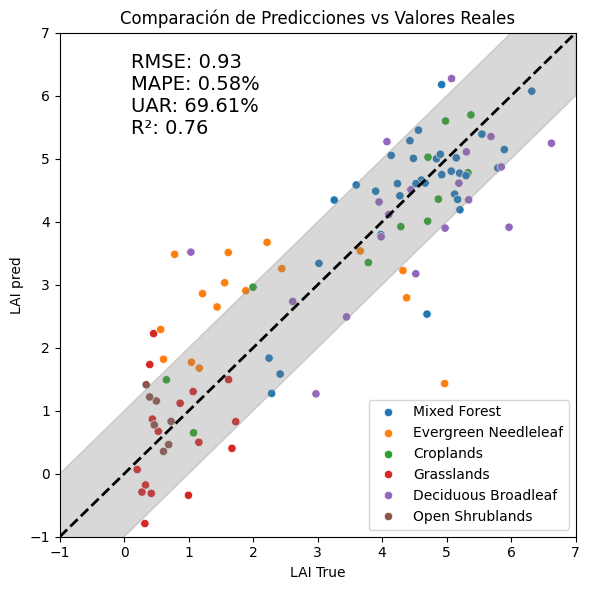

In [ ]:
# Crear figura
plt.figure(figsize=(6, 6))

# Scatter plot
sns.scatterplot(data=df_result, x="LAI_Warren", y="pred", hue="Class")

# Línea de identidad
x_vals = [-1, 7]
plt.plot(x_vals, x_vals, 'k--', lw=2)

# Sombra entre y = x - 1 y y = x + 1
plt.fill_between(x_vals,
                 [x - 1 for x in x_vals],
                 [x + 1 for x in x_vals],
                 color='gray', alpha=0.3)

plt.xlim(-1, 7)
plt.ylim(-1, 7)

plt.xlabel('LAI True')
plt.ylabel('LAI pred')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.legend()

# Métricas de evaluación
mse = 0.8698939744213738
rmse = 0.9326810679012273
mae = 0.7471742889314568
mape = 0.5776311680298556
r2 = 0.7606785786442964

# Texto de métricas en el gráfico
metric_text = (#f"MSE: {mse:.2f}\n"
               f"RMSE: {rmse:.2f}\n"
               #f"MAE: {mae:.2f}\n"
               f"MAPE: {mape:.2f}%\n"
               f"UAR: {UAR*100:.2f}%\n"
               f"R²: {r2:.2f}")

plt.text(0.1, 5.4, metric_text, fontsize=14)

plt.tight_layout()
plt.show()


### Graficamos una serie temporal de LAI

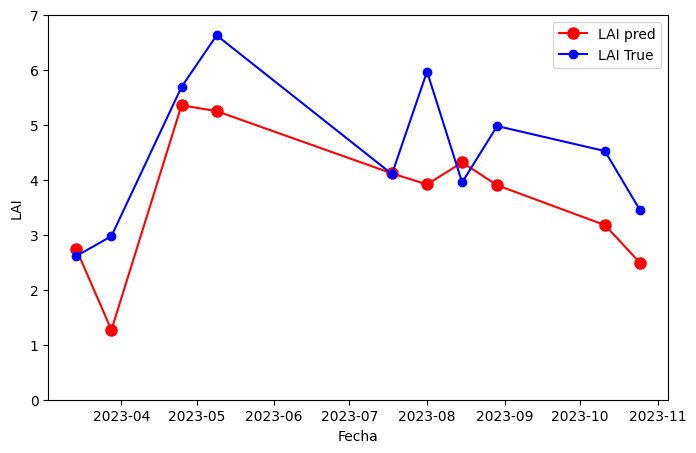

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(
    test_set[test_set['Site'] == 'Dead Lake']['date_insitu'],
    y_pred[test_set['Site'] == 'Dead Lake'],
    marker='o',
    markerfacecolor='red',
    markeredgecolor='red',
    markersize=8,
    linestyle='-',
    color='red',
    label='LAI pred'
)

plt.plot(
    test_set[test_set['Site'] == 'Dead Lake']['date_insitu'],
    y_test[test_set['Site'] == 'Dead Lake'],
    marker='o',
    markerfacecolor='blue',
    markeredgecolor='blue',
    markersize=6,
    linestyle='-',
    color='blue',
    label='LAI True'
)

plt.ylabel('LAI')
plt.xlabel('Fecha')
plt.ylim(0,7)
plt.legend()
